# Step 1: Generate Particles

In [2]:
from advectionGP.sensors import FixedSensorModel, RemoteSensingModel
sensors = RemoteSensingModel()
particles = sensors.genParticles(Nparticles=10)  # shape: (1, num_obs, 3)
# particles = particles.transpose(1, 0, 2)  # → shape: (num_obs, 1, 3)


In [3]:
import pandas as pd
import numpy as np
from pyproj import Proj
from scipy.spatial import cKDTree
from netCDF4 import Dataset
from datetime import datetime, timedelta

class RealWind:
    def __init__(self, start_date="2019-10-01", num_days=9):
        """
        Precompute and store wind data in a pandas DataFrame for fast lookup.
        The table includes time (in minutes), northing, easting, U (east wind), and V (north wind).
        """
        self.proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
        self.wind_table = []  # List to accumulate wind data

        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        layer_range = (56, 68)  # Height range for averaging wind speeds
        bounding_box = (140.5, -39, 150, -34)

        for day_offset in range(num_days):
            current_date = start_date + timedelta(days=day_offset)
            date_str = current_date.strftime('%Y%m%d')
            file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.{date_str}.nc4"

            try:
                dataset = Dataset(file_path, 'r')
                lats = dataset.variables['lat'][:]
                lons = dataset.variables['lon'][:]
                
                # Apply the bounding box filter
                lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
                lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]

                lats = lats[lat_indices]
                lons = lons[lon_indices]

                # Load and filter wind data within the bounding box
                eastward_wind = dataset.variables['U'][:, :, lat_indices, :][:, :, :, lon_indices]
                northward_wind = dataset.variables['V'][:, :, lat_indices, :][:, :, :, lon_indices]

                # Average over the specified vertical layers
                layer_range_slice = slice(layer_range[0], layer_range[1])
                eastward_wind_avg = np.mean(eastward_wind[:, layer_range_slice, :, :], axis=1)
                northward_wind_avg = np.mean(northward_wind[:, layer_range_slice, :, :], axis=1)

                # Read and store time directly in minutes
                print("NASA Time Units:", dataset.variables['time'].units)
                time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!

                for t_idx, t_val in enumerate(time_var):
                    if not np.isfinite(t_val):
                        continue  # Skip invalid time values
                    timestamp = t_val *60 #convert minutes to seconds

                    # Vectorized coordinate transformation
                    lon_grid, lat_grid = np.meshgrid(lons, lats)
                    easting, northing = self.proj(lon_grid, lat_grid)

                    # Flatten arrays to create a table of points
                    easting = easting.flatten()
                    northing = northing.flatten()
                    u_wind = eastward_wind_avg[t_idx].flatten()
                    v_wind = northward_wind_avg[t_idx].flatten()

                    # Filter out invalid projections
                    valid_mask = np.isfinite(easting) & np.isfinite(northing) & np.isfinite(u_wind) & np.isfinite(v_wind)

                    # Append valid data to the wind table
                    self.wind_table.extend(
                        zip([timestamp] * np.sum(valid_mask),
                            northing[valid_mask],
                            easting[valid_mask],
                            u_wind[valid_mask],
                            v_wind[valid_mask])
                    )

                dataset.close()

            except FileNotFoundError:
                print(f"File for {date_str} not found.")
            except Exception as e:
                print(f"Error loading {date_str}: {e}")

        # Convert to pandas DataFrame for fast lookups
        self.wind_table = pd.DataFrame(self.wind_table, columns=["Timestamp", "Northing", "Easting", "East Wind", "North Wind"])

        # Clean data: Drop NaN or Inf values
        self.wind_table = self.wind_table.replace([np.inf, -np.inf], np.nan)
        self.wind_table = self.wind_table.dropna()

        # Sort by timestamp for faster temporal queries
        self.wind_table = self.wind_table.sort_values(by="Timestamp").reset_index(drop=True)

        # Build a spatial KD-Tree for efficient spatial querying
        self.wind_tree = cKDTree(self.wind_table[["Easting", "Northing"]].values)

        print(f"Wind data precomputed for {len(self.wind_table)} points across {num_days} days.")
    
    def getwind(self, coords):
        """
        Get the nearest-neighbor wind speed for particles at given positions and times.

        Parameters:
        - coords: A tensor of shape (num_particles, num_observations, 3)
                  where each entry is [time, easting, northing].

        Returns:
        - wind_data: A tensor of shape (num_particles, num_observations, 2)
                     where each entry is [east_wind_speed, north_wind_speed].
        """
        num_particles, num_observations, _ = coords.shape
        wind_data = np.full((num_particles, num_observations, 2), np.nan)  # Initialize with NaN

        timestamps = coords[:, :, 0].flatten()  # Keep time in minutes

        for i in range(num_particles):
            for j in range(num_observations):
                easting, northing = coords[i, j, 1], coords[i, j, 2]
                timestamp = timestamps[i * num_observations + j]

                closest_time_idx = (np.abs(self.wind_table["Timestamp"] - timestamp)).idxmin()
                dist, closest_idx = self.wind_tree.query([easting, northing], k=1)

                wind_data[i, j] = self.wind_table.loc[closest_idx, ["East Wind", "North Wind"]]

        return wind_data


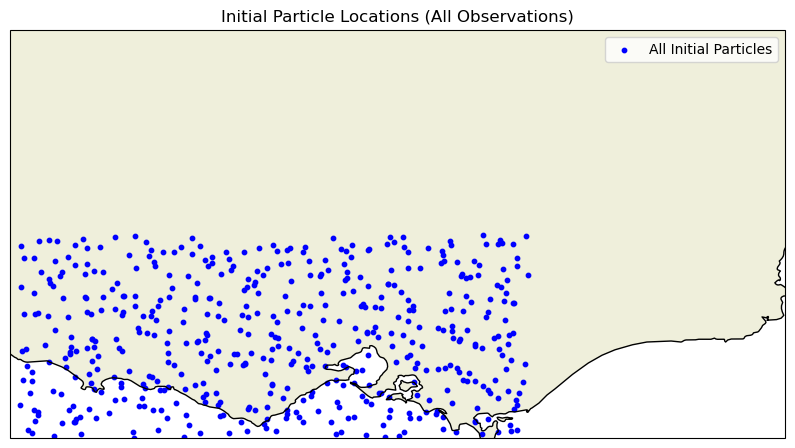

In [4]:
from pyproj import Transformer
# Reshape to flat (Nparticles × Nobs, 3)
flat_particles = particles.reshape(-1, 3)

# Convert to lat/lon
transformer = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(flat_particles[:, 1], flat_particles[:, 2])
# Plot with Cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.scatter(lon, lat, s=10, c='blue', label="All Initial Particles")
ax.legend()
plt.title("Initial Particle Locations (All Observations)")
plt.show()



In [5]:
print("Particles shape:", particles.shape)


Particles shape: (10, 50, 3)


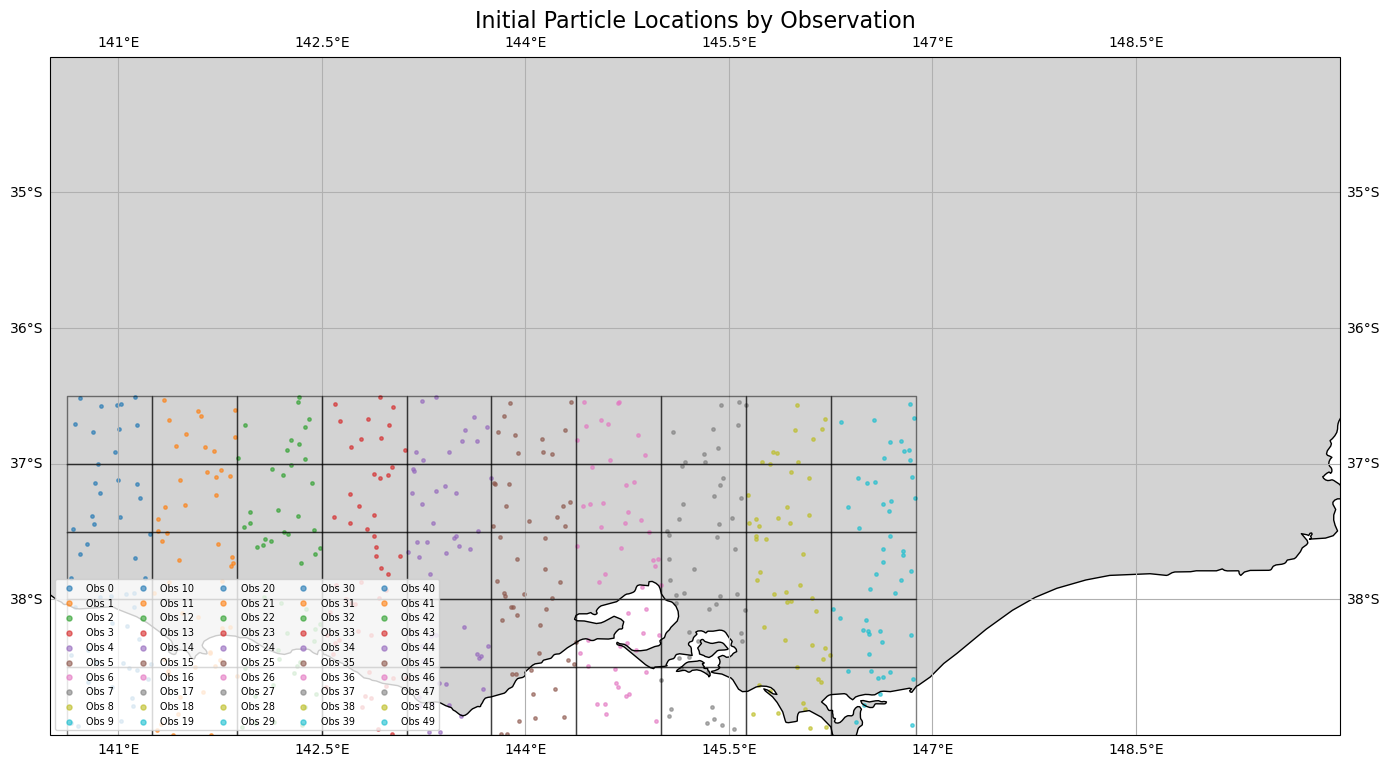

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer

# Transformer for UTM Zone 56S → Lat/Lon
transformer = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# Generate particles
from advectionGP.sensors import RemoteSensingModel
sensors = RemoteSensingModel()
particles = sensors.genParticles(Nparticles=10)  # (Nparticles, Nobs, 3)

# Plot
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])  # Australia - Victoria region
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True)

num_particles, num_obs, _ = particles.shape

# --- Plot grid polygons ---
for polygon in sensors.grid_polygons:
    x, y = polygon.exterior.xy
    lon, lat = transformer.transform(x, y)
    ax.plot(lon, lat, color='black', linewidth=1, alpha=0.5, transform=ccrs.PlateCarree())

# Color each observation group separately
for obs_idx in range(num_obs):
    easting = particles[:, obs_idx, 1]
    northing = particles[:, obs_idx, 2]
    lon, lat = transformer.transform(easting, northing)
    
    ax.scatter(lon, lat, s=6, alpha=0.6, label=f"Obs {obs_idx}")

# Optional: reduce cluttered legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize="x-small", ncol=5, loc="lower left", markerscale=1.5)

plt.title("Initial Particle Locations by Observation", fontsize=16)
plt.tight_layout()
plt.show()


NASA Time Units: minutes since 2019-10-01 01:30:00
Wind data precomputed for 1408 points across 1 days.


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


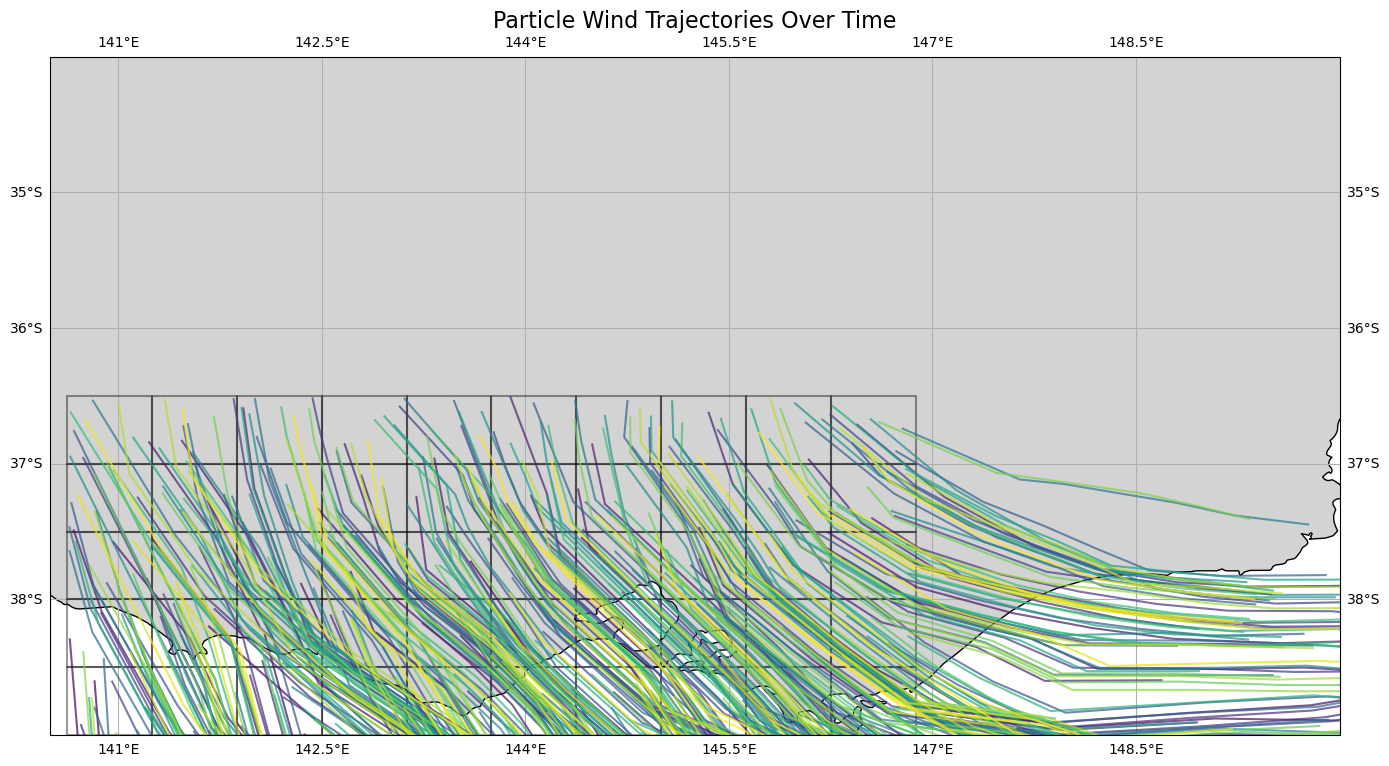

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer
from advectionGP.sensors import RemoteSensingModel



# --- Settings ---
timesteps = 6
t_step = 3 * 3600  # 3 hours in seconds
k_0 = 50  # Diffusion constant

# --- Transformer ---
transformer = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# --- Initialize sensor and particles ---
sensors = RemoteSensingModel()
particles = sensors.genParticles(Nparticles=10)  # shape: (Nparticles, Nobs, 3)

# We simulate all particles as a flat array: shape (N, 1, 3)
num_particles, num_obs, _ = particles.shape
particles = particles.reshape(-1, 1, 3)  # shape: (N, 1, 3)

# --- Wind model ---
windmodel = RealWind(start_date="2019-10-01", num_days=1)

# --- Store trajectories for plotting ---
trajectories = [particles.copy()]

for step in range(timesteps):
    wind = windmodel.getwind(particles)  # (N, 1, 2)

    # Update position using advection + diffusion
    particles[:, 0, 1:] += wind[:, 0, :] * t_step
    particles[:, 0, 1:] += np.random.randn(*particles[:, 0, 1:].shape) * np.sqrt(2 * t_step * k_0)
    particles[:, 0, 0] += t_step  # update time (in seconds)

    trajectories.append(particles.copy())

# --- Plotting ---
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])  # Victoria region
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True)

# Plot polygons
for poly in sensors.grid_polygons:
    x, y = poly.exterior.xy
    lon, lat = transformer.transform(x, y)
    ax.plot(lon, lat, color='black', alpha=0.4)

# Plot each trajectory path
colors = plt.cm.viridis(np.linspace(0, 1, num_particles * num_obs))
for idx in range(num_particles * num_obs):
    path = np.array([step[idx, 0, 1:] for step in trajectories])  # extract [x, y] over time
    lon, lat = transformer.transform(path[:, 0], path[:, 1])
    ax.plot(lon, lat, linewidth=1.5, alpha=0.7, color=colors[idx])

plt.title("Particle Wind Trajectories Over Time", fontsize=16)
plt.tight_layout()
plt.show()


NASA Time Units: minutes since 2019-10-01 01:30:00
Wind data precomputed for 1408 points across 1 days.


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


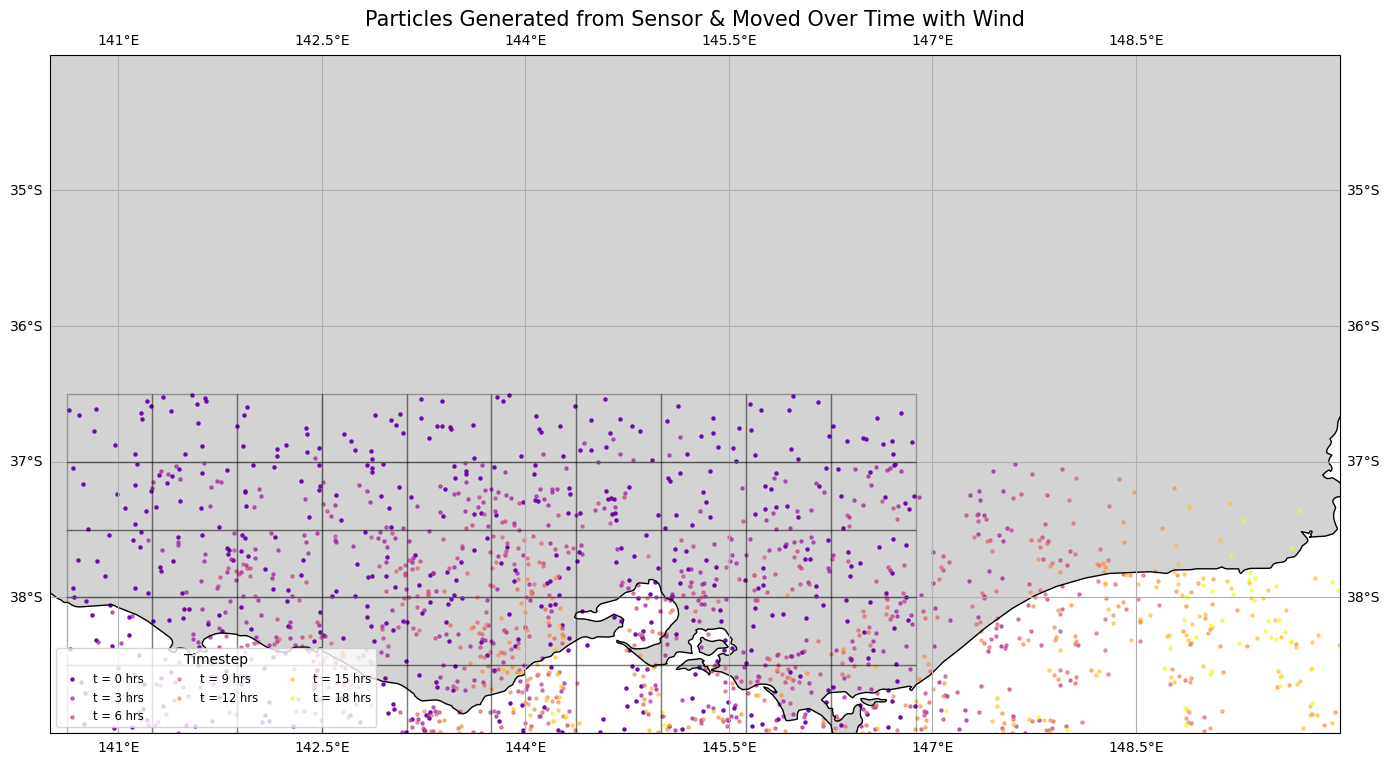

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer
from advectionGP.sensors import RemoteSensingModel
import numpy as np

# --- Sensor & Projection ---
transformer_to_latlon = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)
sensors = RemoteSensingModel()
particles_with_time = sensors.genParticles(Nparticles=10)  # (Nparticles, Nobs, 3)

# Flatten to shape (Nparticles_total, 1, 3)
particles_with_time = particles_with_time.reshape(-1, 1, 3)

# --- Wind & Simulation Config ---

windmodel = RealWind(start_date="2019-10-01", num_days=1)

timesteps = 6
t_step = 3 * 3600  # 3 hours in seconds
k_0 = 100

# --- Plot Setup ---
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])  # Victoria bounds
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

# Plot grid polygons (sensor locations)
for polygon in sensors.grid_polygons:
    x, y = polygon.exterior.xy
    lon, lat = transformer_to_latlon.transform(x, y)
    ax.plot(lon, lat, color='black', linewidth=1, alpha=0.3)

# --- Define Colormap ---
cmap = plt.cm.plasma
colors = cmap(np.linspace(0.2, 1, timesteps + 1))

# --- Initial State ---
lon, lat = transformer_to_latlon.transform(
    particles_with_time[:, 0, 1], particles_with_time[:, 0, 2]
)
ax.scatter(lon, lat, s=5, alpha=0.9, color=colors[0], label="t = 0 hrs")

# --- Particle Movement Over Time ---
for step in range(1, timesteps + 1):
    wind = windmodel.getwind(particles_with_time)  # (Nparticles_total, 1, 2)

    # Update: wind + diffusion
    particles_with_time[:, 0, 1:] += wind[:, 0, :] * t_step
    particles_with_time[:, 0, 1:] += np.random.randn(*particles_with_time[:, 0, 1:].shape) * np.sqrt(2 * t_step * k_0)
    particles_with_time[:, 0, 0] += t_step

    # Plot this timestep
    lon, lat = transformer_to_latlon.transform(
        particles_with_time[:, 0, 1], particles_with_time[:, 0, 2]
    )
    ax.scatter(lon, lat, s=5, alpha=0.6, color=colors[step], label=f"t = {step * t_step / 3600:.0f} hrs")

# --- Final Touches ---
plt.legend(title="Timestep", fontsize="small", loc="lower left", ncol=3)
plt.title("Particles Generated from Sensor & Moved Over Time with Wind", fontsize=15)
plt.tight_layout()
plt.show()


In [ ]:
wind = windmodel.getwind(particles)  # Should not throw or return NaNs
print("Wind shape:", wind.shape)
print("Sample wind vectors:", wind[:5, 0])


NASA Time Units: minutes since 2019-10-01 01:30:00
Wind data precomputed for 1408 points across 1 days.


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


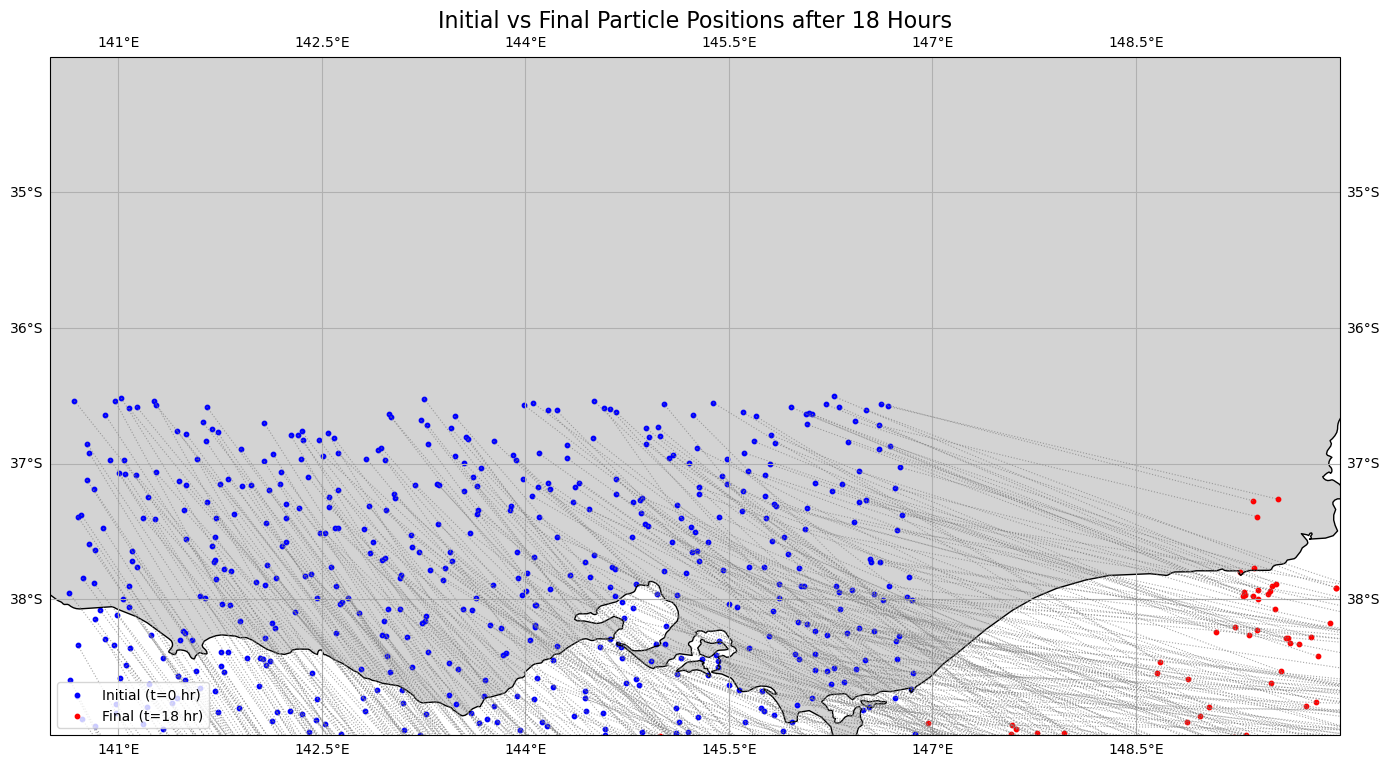

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer
import numpy as np
from advectionGP.sensors import RemoteSensingModel

# --- Initialize Sensor and Projector ---
sensors = RemoteSensingModel()
proj_to_latlon = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# --- Generate Particles ---
particles = sensors.genParticles(Nparticles=10).reshape(-1, 1, 3)  # shape: (N, 1, 3)
initial_positions = particles.copy()

# --- Wind Config ---
windmodel = RealWind(start_date="2019-10-01", num_days=1)
t_step = 3 * 3600  # 3 hours in seconds
k_0 = 100
timesteps = 6

# --- Simulate Movement for 18 Hours ---
for _ in range(timesteps):
    wind = windmodel.getwind(particles)
    particles[:, 0, 1:] += wind[:, 0, :] * t_step
    particles[:, 0, 1:] += np.random.randn(*particles[:, 0, 1:].shape) * np.sqrt(2 * t_step * k_0)
    particles[:, 0, 0] += t_step

final_positions = particles.copy()

# --- Convert to Lat/Lon for Plotting ---
lon_init, lat_init = proj_to_latlon.transform(initial_positions[:, 0, 1], initial_positions[:, 0, 2])
lon_final, lat_final = proj_to_latlon.transform(final_positions[:, 0, 1], final_positions[:, 0, 2])

# --- Plot ---
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])  # Victoria bounds
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

# Plot initial positions
ax.scatter(lon_init, lat_init, color='blue', s=10, label="Initial (t=0 hr)")

# Plot final positions
ax.scatter(lon_final, lat_final, color='red', s=10, label="Final (t=18 hr)")

# Draw dotted lines connecting initial to final
for i in range(len(lon_init)):
    ax.plot([lon_init[i], lon_final[i]], [lat_init[i], lat_final[i]],
            color='gray', linestyle='dotted', linewidth=0.8, alpha=0.7)

plt.title("Initial vs Final Particle Positions after 18 Hours", fontsize=16)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [16]:
from scipy.spatial.distance import euclidean

# Compute Euclidean distance in meters for each particle (in UTM)
distances = np.linalg.norm(final_positions[:, 0, 1:] - initial_positions[:, 0, 1:], axis=1)

# Print stats
print("=== Particle Travel Distance Summary (in meters) ===")
print(f"Min:    {np.min(distances):.2f} m")
print(f"Max:    {np.max(distances):.2f} m")
print(f"Mean:   {np.mean(distances):.2f} m")
print(f"Median: {np.median(distances):.2f} m")


=== Particle Travel Distance Summary (in meters) ===
Min:    256689.50 m
Max:    597388.62 m
Mean:   422702.53 m
Median: 437249.99 m


NASA Time Units: minutes since 2019-10-01 01:30:00
Wind data precomputed for 1408 points across 1 days.


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_29416\2400407666.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


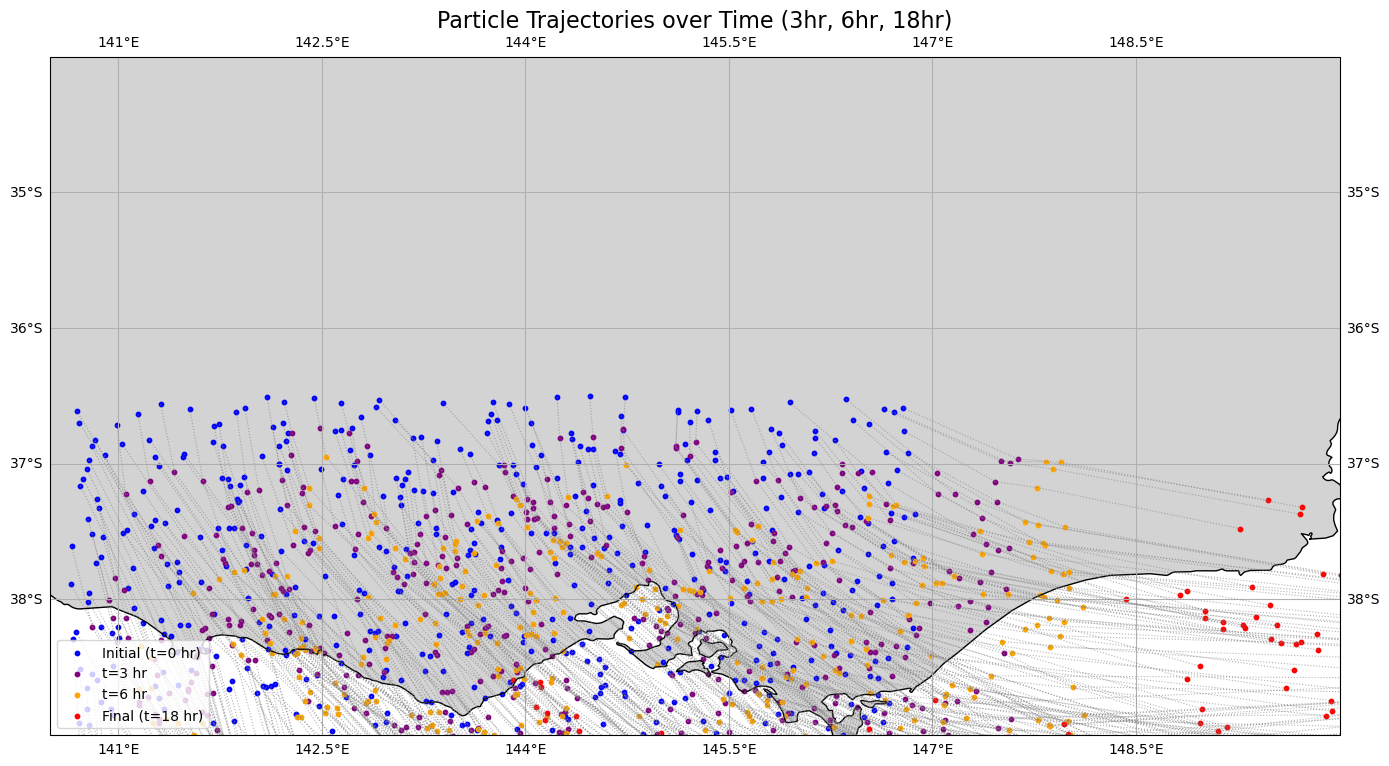

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer
import numpy as np

# --- Initialize Sensor and Projector ---
from advectionGP.sensors import RemoteSensingModel
sensors = RemoteSensingModel()
proj_to_latlon = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# --- Generate Particles ---
particles = sensors.genParticles(Nparticles=10).reshape(-1, 1, 3)  # shape: (N, 1, 3)
initial_positions = particles.copy()

# --- Wind Config ---
windmodel = RealWind(start_date="2019-10-01", num_days=1)
t_step = 3 * 3600  # 3 hours in seconds
k_0 = 100
timesteps = 6

# --- Store positions for 0, 3, 6, 18 hours ---
positions_over_time = {0: initial_positions.copy()}

for step in range(1, timesteps + 1):
    wind = windmodel.getwind(particles)
    particles[:, 0, 1:] += wind[:, 0, :] * t_step
    particles[:, 0, 1:] += np.random.randn(*particles[:, 0, 1:].shape) * np.sqrt(2 * t_step * k_0)
    particles[:, 0, 0] += t_step
    if step in [1, 2, 6]:  # Store 3hr, 6hr, and final 18hr positions
        positions_over_time[step * 3] = particles.copy()

# --- Plot ---
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])  # Victoria bounds
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

# Colors for each timestamp
time_colors = {
    0: 'blue',
    3: 'purple',
    6: 'orange',
    18: 'red'
}
time_labels = {
    0: "Initial (t=0 hr)",
    3: "t=3 hr",
    6: "t=6 hr",
    18: "Final (t=18 hr)"
}

# Convert and plot positions
latlon_positions = {}
for hour, pos in positions_over_time.items():
    lon, lat = proj_to_latlon.transform(pos[:, 0, 1], pos[:, 0, 2])
    latlon_positions[hour] = (lon, lat)
    ax.scatter(lon, lat, color=time_colors[hour], s=10, label=time_labels[hour])

# Connect each particle's journey with dotted lines
for i in range(particles.shape[0]):
    for h_start, h_end in zip([0, 3, 6], [3, 6, 18]):
        lon_start, lat_start = latlon_positions[h_start][0][i], latlon_positions[h_start][1][i]
        lon_end, lat_end = latlon_positions[h_end][0][i], latlon_positions[h_end][1][i]
        ax.plot([lon_start, lon_end], [lat_start, lat_end],
                color='gray', linestyle='dotted', linewidth=0.8, alpha=0.6)

plt.title("Particle Trajectories over Time (3hr, 6hr, 18hr)", fontsize=16)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
